# Importing packages, modules and data

In [39]:
import sys
import os
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
import seaborn as sns
import missingno as msno
from sklearn.linear_model import LinearRegression
import ipywidgets as widg
from ipywidgets import interact, interact_manual

colab = 'google.colab' in sys.modules
in_mem = os.path.exists("Medium-Data-Exploration/invoices.csv")\
         or os.path.exists("/content/Medium-Data-Exploration/invoices.csv")

if colab:
    from google.colab import files

In [40]:
if not in_mem:
    !git clone https://github.com/FBosler/Medium-Data-Exploration.git
else:
    if colab :
        dfinvoices = pd.read_csv("/content/Medium-Data-Exploration/invoices.csv")
        dfoleads = pd.read_csv("/content/Medium-Data-Exploration/order_leads.csv")
        dfsales = pd.read_csv("/content/Medium-Data-Exploration/sales_team.csv")
    else:
        dfinvoices = pd.read_csv("Medium-Data-Exploration/invoices.csv")
        dfoleads = pd.read_csv("Medium-Data-Exploration/order_leads.csv")
        dfsales = pd.read_csv("Medium-Data-Exploration/sales_team.csv")

# First Overview


In [41]:
# Printing sampled rows of the dataframes

@interact_manual
def print_sample(x=['invoices', 'order leads', 'sales'], n=(0,10,1)):
  d = {'invoices': dfinvoices, 
       'order leads': dfoleads,
       'sales': dfsales}
  return d[x].sample(n)

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

In [42]:
# Describing each of the 3 dataframes

@interact_manual
def print_sample(x=['invoices', 'order leads', 'sales']):
  d = {'invoices': dfinvoices, 
       'order leads': dfoleads,
       'sales': dfsales}
  return d[x].describe(include='all')

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

In [43]:
# Verifying that there is no null value on the 3 dataframes

@interact_manual
def print_msno(x=['invoices', 'order leads', 'sales'],\
               y=[ 'bars','heatmap', 'matrix']):
  d = {'invoices': dfinvoices, 'order leads': dfoleads,'sales': dfsales}
  if y=="heatmap":
    return msno.heatmap(d[x],figsize=(8,3))
  elif y=="matrix":
    return msno.matrix(d[x],figsize=(8,3))
  else:
    return msno.bar(d[x],figsize=(8,3))

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

In [44]:
# Checking the format of data

@interact_manual
def check_dtypes(x=['invoices', 'order leads', 'sales']):
  d = {'invoices': dfinvoices, 'order leads': dfoleads,'sales': dfsales}
  return d[x].dtypes

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

# Formatting the data

In [45]:
# Checking and modifying format of the dates

dfoleads["Date"] = pd.DatetimeIndex(dfoleads["Date"])
dfinvoices["Date of Meal"] = pd.DatetimeIndex(dfinvoices["Date of Meal"])

In [58]:
# dfinvoices.drop(columns=["Participants List", "Number of Participants"], inplace=True)

In [66]:
# Splitting "participants", getting the nb of part. and their list for each meal

def split_part(long_string):
  _=long_string.split(sep='\n')
  _=[s.strip("\"'[] ").split(sep="' '") for s in _]
  return list(itertools.chain.from_iterable(_))


dfinvoices.insert(4, "Participants List",\
                  dfinvoices["Participants"].apply(split_part))
dfinvoices.insert(5, "Number of Participants",\
                  dfinvoices["Participants List"].apply(len))

ValueError: cannot insert Participants List, already exists

In [67]:
# Are the Sales Rep considered as participants of the meal ?

li_sales_rep = np.array(dfsales["Sales Rep"].unique())
ser = dfinvoices["Participants List"]
np.array(ser)
# li_temp = [ser.str.contains(s).sum() for s in li_sales_rep]
# np.histogram(li_temp) # --> No

array([<itertools.chain object at 0x000001C30B0F8B70>,
       <itertools.chain object at 0x000001C30B2136D8>, ...,
       <itertools.chain object at 0x000001C30FB41668>], dtype=object)

# Exploration
## Order Leads
### Order leads through time

In [48]:
plt.rcParams['figure.facecolor'] = (1,1,1,1)

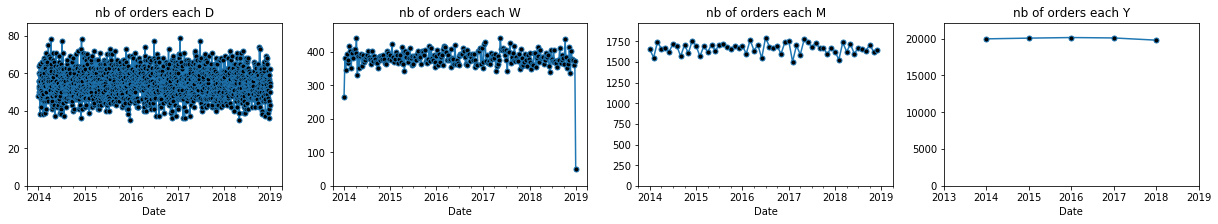

In [49]:
# Nb of order leads through time (day, week, month, year)

fig, axs = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(21,3)
fig.subplots_adjust(wspace=0.2)
for i,per in enumerate(['D', 'W', 'M', 'Y'],0):
  ser = dfoleads.groupby(pd.Grouper(key='Date',freq=per)).size()
  ser.plot(ax=axs[i], ms=5, marker='o', mfc='k', ls='-')
  axs[i].set(xlim=('2013-10-01','2019-04-01'),ylim=(0,max(ser)*1.1))
  axs[i].set_title("nb of orders each "+per)

---> Constant frequency of order leads from 2014 to 2019.

In [27]:
''' Function that calculates for each row of df (can be used with a groupby) :
- the value of converted order leads: case "my_tuple[1]==True"
- OR the value of non converted leads: case "my_tuple[1]==False"
Each result is aggregated with
- np.sum: case "my_tuple[0]=='sum'"
- OR np.mean: case "my_tuple[0]=='mean'"
'''

def agg_val_c_or_d(df, my_tuple):
  my_fun, c_or_d = my_tuple
  col_Conv = df['Converted'] if c_or_d else 1-df['Converted']
  if my_fun == 'mean':
    return np.mean(df['Order Value']*col_Conv)
  elif my_fun == 'sum':
    return np.sum(df['Order Value']*col_Conv)
  else:
    print("unknown function")
    return None

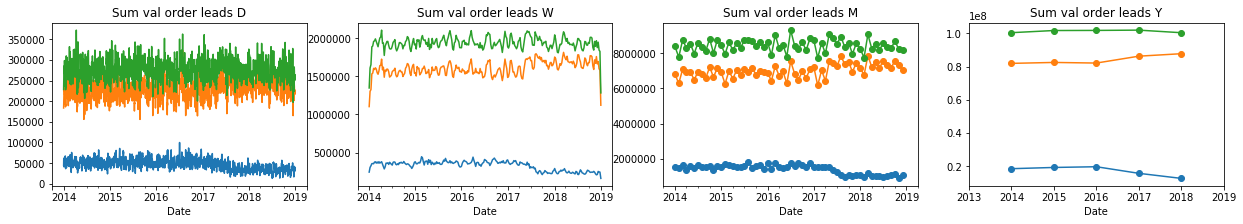

In [32]:
# Value of order leads through time (day, week, month, year)
#  total vs. converted vs. not converted

fig, axs = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(21,3)
fig.subplots_adjust(wspace=0.2)
f_roll = lambda x: x.rolling(3, min_periods=1).mean()
for i,per in enumerate(['D', 'W', 'M', 'Y'],0):
  gb = dfoleads.groupby(pd.Grouper(key='Date',freq=per))
  ser_c = gb.apply(agg_val_c_or_d, ('sum', True))
  ser_d = gb.apply(agg_val_c_or_d, ('sum', False))
  if per in ['D', 'W']:
    f_roll(ser_c).plot(ax=axs[i])
    # axs[i].annotate('coucou',xy=(0, 0))
    f_roll(ser_d).plot(ax=axs[i], ) 
    (f_roll(ser_c)+f_roll(ser_d)).plot(ax=axs[i]) 
  else:
    ser_c.plot(ax=axs[i],marker='o')
    ser_d.plot(ax=axs[i],marker='o')
    (ser_c+ser_d).plot(ax=axs[i],marker='o') #ms=5, marker='o', mfc='k', ls='-'
  axs[i].set(xlim=('2013-10-01','2019-04-01'))
  axs[i].set_title("Sum val order leads "+per)

Constant value of the order leads.

In April 2017, value of the converted order leads is going down. As we've noticed before, the nb of orders remains the same. Therefore, a drop in the conversion rate is to blame.

In [33]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(d).dropna(how='any')
# df = pd.DataFrame(data={'cx': X, 'cwxc': Y}).dropna(how='any')

In [34]:
def get_reg(X,Y):
  df = pd.DataFrame({'x': X, 'y': Y}).dropna(how='any')
  x_, y_  = [(df.loc[:,c]).values.reshape(-1,1) for c in df.columns]
  x__ = x_-x_[0]
  reg = LinearRegression().fit(x__,y_)
  return reg

NameError: name 'mean_val_c_or_d' is not defined

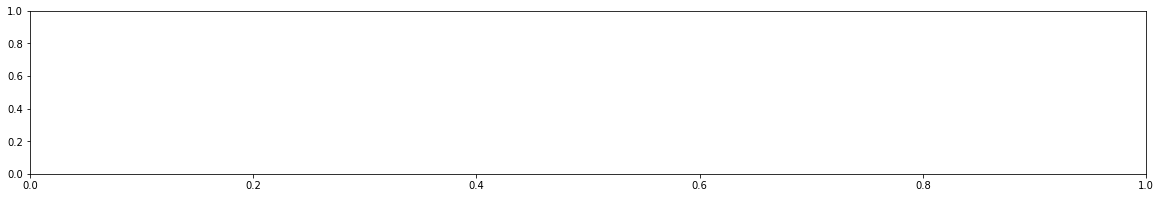

In [35]:
# Mean conv. rate, dismissed commands and confirmed commands on 30 rolling days

fig, axs = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20,3)
n_roll = 30
gb = dfoleads.groupby(pd.Grouper(key='Date',freq='D'))
conv_r_mean = gb['Converted'].mean().rolling(n_roll).mean()
val_c = gb.apply(mean_val_c_or_d, True).rolling(n_roll).mean()
val_d = gb.apply(mean_val_c_or_d, False).rolling(n_roll).mean()

ax = plt.gca()
ax.stackplot(val_c.index, [val_c.values, val_d.values],\
             labels=['confirmed commands', 'dismissed commands'])
ax.plot(val_c+val_d, label='total value of order leads')
X = mpd.date2num(val_c.index)
Y = (val_c+val_d).values
sns.regplot(x=X, y=Y,
            ax=ax, label='total value of order leads (lin. reg.)',
            scatter=False, color='g')

ax.xaxis.set_major_formatter(dates.DateFormatter("%m/%Y"))
ax.xaxis.set_tick_params(rotation=45)

ax.legend(loc='center right')
ax.set_title(f"Mean value of Commands ({n_roll} rolling days)"+per)
plt.show()

reg = get_reg(X,Y)
my_text = 'y = {:.5f} * x + {:.0f}'.format(reg.coef_.ravel()[0],
                                        reg.intercept_.ravel()[0])
ax.annotate(text=my_text, xy=(0,0), )

In [309]:
my_text

'y = 0.02932 * x + 5039'

In [188]:
pd.DataFrame({'x': X, 'y': Y}).dropna(how='any')

,x,y
29,735263.0,5090.356216
30,735264.0,5089.282528
31,735265.0,5079.019636
32,735266.0,5083.501949
33,735267.0,5090.451343
...,...,...
1821,737055.0,4956.808693
1822,737056.0,4978.507698
1823,737057.0,4961.125066
1824,737058.0,4956.995512


In [168]:
import matplotlib.dates as mpd

my_date = ['1975-12-03', '2008-08-20', '2011-03-16']
my_num_dates = mpd.datestr2num(my_date)
my_datetimes = mpd.num2date(my_num_dates)
[d.strftime('%d/%m/%Y') for d in my_datetimes]

['03/12/1975', '20/08/2008', '16/03/2011']

In [162]:
my_date[0]

datetime.datetime(1975, 12, 3, 0, 0, tzinfo=datetime.timezone.utc)

Same conclusion as above, with average on 30 rolling days.

In [0]:
# What about the evolution of the number of meals, number of participants,
# price of the meals through time ?